In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Roger Varney"
user_email = "roger.varney@sri.com"
user_affiliation = "SRI International"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://cedar.openmadrigal.org/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2018,12,22,0,0,0)
et=datetime.datetime(2018,12,23,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100170700
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100170700
url: http://cedar.openmadrigal.org/madtoc/experiments3/2018/pfa/21dec18h
name: IPY27_Tracking_v03 - Long duration measurements in support of the International Polar Year
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 21
starthour: 14
startmin: 1
startsec: 1
endyear: 2018
endmonth: 12
endday: 22
endhour: 4
endmin: 20
endsec: 4
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1550715266
access: 0
Madrigal version: 3.0

id: 100170719
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100170719
url: http://cedar.openmadrigal.org/madtoc/experiments3/2018/pfa/22dec18a
name: MSWinds26.v03 - D-region E-region F-region local measurements
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 22
s

In [5]:
print(expList[4])

id: 100171026
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100171026
url: http://cedar.openmadrigal.org/madtoc/experiments3/2018/pfa/22dec18h
name: PLCal30 - Plasma line calibration run
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 22
starthour: 18
startmin: 0
startsec: 49
endyear: 2018
endmonth: 12
endday: 23
endhour: 0
endmin: 0
endsec: 4
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1547618631
access: 0
Madrigal version: 3.0



In [6]:
fileList = maddat.getExperimentFiles(expList[4].id)
lpfile=None
for file in fileList:
    if re.match('Long Pulse Uncorrected Ne',file.kindatdesc):
        lpfile=file
        
filename=lpfile.name
outfilename=lpfile.name.split('/')[-1]
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/popl'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dpopl'][:])
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']/np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64112.0 -154.3 84.5
64124.0 -154.3 80.5
64157.0 -154.3 77.5
64982.0 15.0 74.0
65162.0 15.0 83.0


In [9]:
#find the vertical beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==90.0:
        bind=i
bdat=PFISR_data[bind]

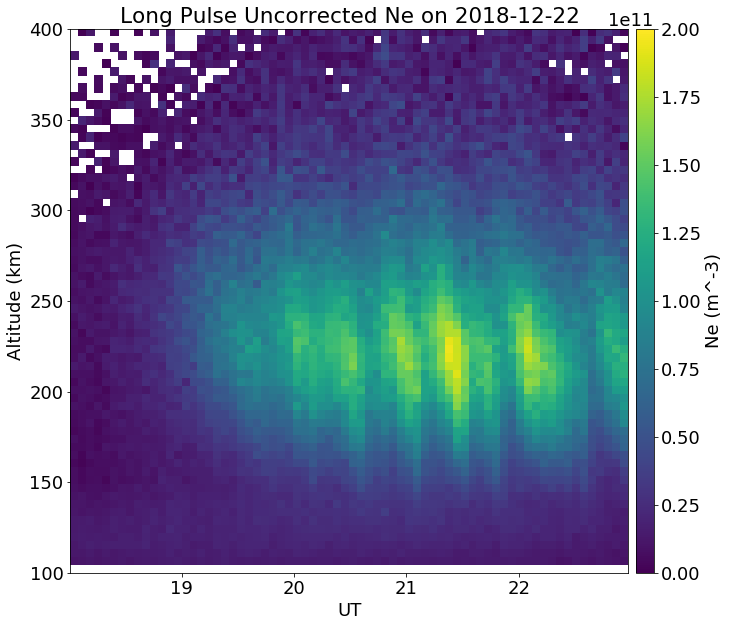

In [10]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,ax=plt.subplots(1,1)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)

ax.set_ylim([100,400])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Long Pulse Uncorrected Ne on 2018-12-22')

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')